# Handwritten digit recognition

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Data import

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame = False)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [10]:
X, y = mnist.data, mnist.target

In [11]:
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

In [18]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

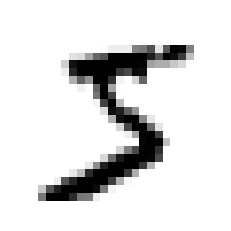

In [19]:
some_digit = X[0]
plot_digit(some_digit)

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [28]:
X_train, X_val, y_train, y_val = X_train[:50000], X_train[50000:], y_train[:50000], y_train[50000:]

In [29]:
X_train.shape

(50000, 784)

In [30]:
X_val.shape

(10000, 784)

In [31]:
X_test.shape

(10000, 784)

Model 1: Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [40]:
from sklearn.pipeline import Pipeline, make_pipeline

In [42]:
help(make_pipeline)

Help on function make_pipeline in module sklearn.pipeline:

make_pipeline(*steps, memory=None, verbose=False)
    Construct a :class:`Pipeline` from the given estimators.
    
    This is a shorthand for the :class:`Pipeline` constructor; it does not
    require, and does not permit, naming the estimators. Instead, their names
    will be set to the lowercase of their types automatically.
    
    Parameters
    ----------
    *steps : list of Estimator objects
        List of the scikit-learn estimators that are chained together.
    
    memory : str or object with the joblib.Memory interface, default=None
        Used to cache the fitted transformers of the pipeline. By default,
        no caching is performed. If a string is given, it is the path to
        the caching directory. Enabling caching triggers a clone of
        the transformers before fitting. Therefore, the transformer
        instance given to the pipeline cannot be inspected
        directly. Use the attribute ``nam

In [44]:
from sklearn.preprocessing import StandardScaler

In [48]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression(solver = 'newton-cg'))

In [49]:
#log_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])

In [76]:
from sklearn.metrics import accuracy_score

In [77]:
accuracy_score(log_clf.predict(X_val), y_val)

0.9224

In [79]:
from joblib import dump, load

In [80]:
dump(log_clf, './models/mnist_log.joblib')

['./models/mnist_log.joblib']

In [ ]:
log_clf = load('./models/mnist_log.joblib')